In [1]:
#Modify the PATH accordingly to import colloids
colloids_path = '/Users/am15146/Documents/Tracking_codes/colloids/python'
path_ = '/Users/am15146/Documents/Tracking_codes/'

import sys
import numpy as np
import pylab as pl
import pickle
from copy import deepcopy
if colloids_path not in sys.path:
    sys.path.append(colloids_path)
    sys.path.append(path_)
import contact_tracking as contacts
from contact_tracking.src import read_lif, menus
from colloids import track, lif
from contact_tracking.src.plotting import sans_serif


# import contactAnalysis as ca
# from contactAnalysis import *
# import read_lif
# import _pickle as cPickle
# import importlib
# importlib.reload(properties)

/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


ImportError: No module named _multiarray_umath

ImportError: No module named _multiarray_umath

ImportError: No module named _multiarray_umath

ImportError: No module named _multiarray_umath

In [2]:
folders = ['/Users/jundong/PhD_3rd/Experiments/STED/2018_04_13/JD1803_1_11phic0_29Cp0_77_decon/',
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_14/JD1803_1_11phic0_30Cp1_09/JD1803_1_11phic0_30Cp1_09_Series009_t0_decon/',
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_14/JD1803_1_11phic0_29Cp1_40_pixel0_127/JD1803_1_11phic0_29Cp1_40_pixel0_127_Series019_decon/',       
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_12/JD1803_1_11phic0_27Cp1_59_decon_t0/',
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_05/JD1803-1_11_phic0_30Cp1_83_decon/',
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_13/JD1803_1_11phic0_29Cp1_88_decon/',
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_10/JD1803-1_11phic0_26Cp1_89_decon/',
           '/Users/jundong/PhD_3rd/Experiments/STED/2018_04_11/JD1803_1_11phic0_37Cp2_18_recheck/JD1803_1_11phic0_37Cp2_18_recheck_t0_decon/']

lif_names = ["JD1803_1_11phic0_29Cp0_77_decon.lif",
             "JD1803_1_11phic0_30Cp1_09_Series009_t0_decon.lif",
             "JD1803_1_11phic0_29Cp1_40_pixel0_127_Series019_decon.lif",
             "JD1803_1_11phic0_27Cp1_59_decon_t0.lif",
             "JD1803-1_11_phic0_30Cp1_83_decon.lif",
             "JD1803_1_11phic0_29Cp1_88_decon.lif",
             "JD1803-1_11phic0_26Cp1_89_decon.lif",
             "JD1803_1_11phic0_37Cp2_18_recheck_t0_decon.lif"]

In [4]:
#### Calculate g(r) to get the distance of the first minimum, to define neighbour distance
from tqdm import tqdm
from contactAnalysis import g_r
t=0
for f in folder_idx:
    print ('folder',f)
    folder = folders[f]
    lif_name = lif_names[f]
    
    gr_resutls = []
    for i in tqdm(range(10)):
        r,GR,IGR,IG=g_r.gr(folder+'t%01d/c1/particle_center.xyz'%t,1,1,1,screen=False)
        p_sigma, maxdistance = g_r.first_minimum(GR)
        gr_resutls.append((p_sigma,maxdistance))
    np.savetxt(folder+'t%01d/c1/gr_dparticle_dneighbour.txt'%t,max(gr_resutls))
    print ('particle diameter',max(gr_resutls)[0],'neighbour distance', max(gr_resutls)[1])

  0%|          | 0/10 [00:00<?, ?it/s]

folder 0


  0%|          | 0/10 [00:00<?, ?it/s]

particle diameter 21 neighbour distance 28
folder 1


  0%|          | 0/10 [00:00<?, ?it/s]

particle diameter 21 neighbour distance 26
folder 6


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]

particle diameter 21 neighbour distance 26


In [1]:
for f in folder_idx:
    print ('folder',f)
    t=0

    #### load both channel images (C1 and C2) from .lif file
    folder = folders[f]  
    reader = read_lif.Reader(folder+lif_names[f])
    series = reader.getSeries()
    image_xyz_c1 = series[0].getFrame(T=t)
    image_xyz_c2 = series[1].getFrame(T=t)
    
    imageC1=np.swapaxes(image_xyz_c1,0,2)      #### z, y, x
    imageC2=np.swapaxes(image_xyz_c2,0,2)      #### z, y, x
    print ('imageC2 shape is', imageC2.shape)

    #### Load coordinates of particles
    pcen_all = np.loadtxt(folder+"t%01d/c1/particle_center.txt"%t)
    print (pcen_all[:,1].max(), pcen_all[:,3].mean())
    pcen = deepcopy(pcen_all)
    
    # index of particles at edges and inside the box
    edge_particle, p_inbox = analysis.remove_edge_particles(imageC2,pcen_all)
    particle_inbox = pcen_all[p_inbox]

    p_cen = particle_inbox
    p_rad = particle_inbox[:,3]
    
    
    #### Calculate the distance of the first minimum in g(r)
    _gr = np.loadtxt(folder+'t%01d/c1/gr_dparticle_dneighbour.txt'%t)
    p_sigma, maxdistance = _gr[0],_gr[1]
    print ('particle diameter',p_sigma,'neighbour distance', maxdistance)

    
     #'###### Calculate volume fraction'
    from contactAnalysis import properties, figures
    sizeFactor = p_sigma/p_cen[:,3].mean()/2
    print (sizeFactor)
    phi,pd,z_first,z_last = properties.volume_fraction(p_cen,imageC2,factor=sizeFactor,z_range=True)
    print (phi,pd,z_first,z_last)

    figures.pd_hist(p_cen[:,3],folder+'t%01d/c1/'%t,bin_number=20)
    f = open(folder+'t%01d/c1/phic_pd_t%01d_removeEdges.txt'%(t,t),'w')
    f.write('%s %s %s' %('phi_c',phi,'\n')) 
    f.write('%s %s %s'%('polydispersity',pd,'\n'))
    f.close()
    
    
#     #### Do not consider the empty space in z direction
#     density_z = properties.phi_of_z(imageC2,folder,bin_z=30,T=1)
#     slices = np.array((int(density_z[1][0]),int(density_z[1][-1])))
#     print ('Validate Z slices between',slices)
    
    
    '''
    OTSU
    
    
    C2 are edges
    '''
    
    # apply Otsu filter twice to the contacts image
    M = imageC2
    slices=np.array((z_first, z_last))
#     slices = np.array((0,imageC2.shape[0]))
    imageC2_part = M[slices[0]:slices[1],:,:]
    print (imageC2_part.shape)
    background =  threshold_otsu(imageC2_part.ravel())
    threshold_contact = threshold_otsu(imageC2_part[imageC2_part>background].ravel())
    print ('background threshold', background)
    print ('contacts threshold', threshold_contact)
    
    
    '''
    TOP_BOTTOM
    '''
    fig.multifigures_xy3(M,120,200,400)        # Check the images with otsu filter
    # threshold images
    I2=deepcopy(M)
    threshold_C2 = ds.threshold_top_bottom(I2,180, threshold_contact*1.05)
    fig.multifigures_xy3(threshold_C2, 120, 200, 400)
    plt.savefig(folder+'threhsold.pdf')
    
    '''
    COORDINATION
    '''
    
    # find middle points between particles
    first_minimum = maxdistance  '''Maxdistance obtained from g(r), this is the first minimum after first peak'''
    '''pcen are particle centres'''
    neigbours_distance, n_p = ds.coordination(pcen,maxdistance=first_minimum)[:2] #To be raplced
    
    ################### Replace by neigbours = ds.get_neighs(centres,maxdist)
    
    # neigbours_distance is a list of 
    #(particle, its neighbour, distances between these two particles)
    # n_p is the number of neighbours
    
    
    middle_mask,particle_middle = ds.middle_point(pcen,neigbours_distance,imageC2)[:2]
    ############### Replace by mask, middle = ds.get_middle_point(centres,neighs,imgc2size)
    
#     imageC2
    
    '''
    DRAW SPHERES
    '''
    mask_thr =0# threshold_contact
    spheres, dimmask,struct_size = ds.draw_spheres(middle_mask,imageC2, mask_thr,s_iter=3,dil_iter=1)
    
    labelled_spheres, num_spheres, sphere_size = ds.label_mask(spheres)
    labelled_new_mask = labelled_spheres

    print ('number of drawn spheres',num_spheres)
    print ('number of middle points',len(particle_middle)/2.)
    'The difference is connected spheres'
    plt.figure()
    plt.hist(sphere_size)
    plt.xlabel('Sphere size (pixels)'),plt.ylabel('Counts')
    plt.savefig(folder+'t%01d/c2/hist_sphereSizes.pdf'%t)
    
    
    '''
    OTSU CONTACTS...FORCE HISTOGRAMS
    '''
    otsu_contacts= ds.force_pdf(I2, labelled_new_mask,threshold_contact)

    thr_low = threshold_contact - 10
    thr_high = threshold_contact + 10
    delta_thr = 4
    low_threshold = range(thr_low,thr_high,delta_thr)
    histograms = [ds.force_pdf(I2,labelled_new_mask,intensity) for intensity in low_threshold]

    for j in range(4):
        scaling = ds.force_plot(histograms,otsu_contacts,scaling=j,threshold_range=low_threshold,
                                otsu_threshold=threshold_contact,fitting=False)
        plt.savefig(folder+"t%01d/c2/pdf_scaling_test_%s_maskThr%02d.pdf"%(t,scaling.real,mask_thr))
                    
    for k in range(len(histograms)):
        histogram = np.array(histograms)[k]
        fname = folder+'t%01d/c2/histograms/maskThr%02d_force_histograms_%s'%(t,mask_thr,histogram[-1])
        ds.write_histogram_file(fname,histogram)

    fname = folder+'t%01d/c2/histograms/maskThr%02d_force_histograms_otsu%s'%(t,mask_thr,np.round(otsu_contacts[-1],0))
    ds.write_histogram_file(fname,otsu_contacts)
    
    
    
#     ////////////////////////////////////
    
    '''
    CONTACT CENTRE
    
    '''
                    
    coms, maxs,shifted_maxs,contact_size,residualContacts,residualLabels = ds.label_contactCentre(I2,
                                                            labelled_new_mask,threshold_contact)[:-1]
    ds.contact_centre_save(np.array(coms),contact_size,
                           folder+'t%01d/c2/particle_middle/c2enters_Contacts_coms_new_maskThr%02d.txt'%(t,mask_thr))
    ds.contact_centre_save(np.array(maxs),contact_size,
                           folder+'t%01d/c2/particle_middle/c2enters_Contacts_maxs_new_maskThr%02d.txt'%(t,mask_thr))
    ds.contact_centre_save(shifted_maxs,contact_size,
                           folder+'t%01d/c2/particle_middle/c2enters_Contacts_shiftedmaxs_new_maskThr%02d.txt'%(t,mask_thr))
        

    '''
    CONTACT COORDINATION
    '''
    
    # Load the coordination of all contacts
    contacts= np.loadtxt(folder+'t%01d/c2/particle_middle/c2enters_Contacts_coms_new_maskThr00.txt'%t)
    removeLarge = contacts[:,-1]<400        #### !!!!!!
    contact_cen_new = contacts[removeLarge][:,:3]
    contact_cen = deepcopy(contact_cen_new)
    contact_size = contacts[removeLarge][:,-1]
    
#     mlab.points3d(p_cen[:,0],p_cen[:,1],p_cen[:,2],scale_factor=15,color=(0,0,0))#,p_cen[:,3])
#     xc = contact_cen[:,0]
#     yc = contact_cen[:,1]
#     zc = contact_cen[:,2]
#     mlab.points3d(xc,yc,zc, scale_factor=5,color=(0,0,1))
#     mlab.show()
    
#     # compute distances between all contacts and particles
    dists=cdist(p_cen[:,:3], contact_cen)
    dists.shape

    # which two particles have a common contact point
    p1_cen, p2_cen, p_tb_connected, connections, forces = analysis.link_particles(
                                dists,contact_cen,contact_size,p_cen)

    #if a contact is not collinear with two adjacent particles, put three of them collinear
    force_vector = analysis.find_force_vector(contact_cen,p1_cen, p2_cen,forces)
    # np.savetxt(folder+'t%01d/c2/particle_middle/force_vector.txt'%t ,force_vector)

    # calculate number of contacts per particle
    # sum of force per particle with magnitude or not
    ncontacts,local_sum,local_sum_moduli,order,local_f_list,local_f_sum = analysis.n_contacts_pparticle(
                                                    p_tb_connected,force_vector,p_cen)
    
    coordinations = analysis.coordination(p_cen,maxdistance)
    np.savetxt(folder+'t%01d/c2/particle_middle/nContacts.txt'%t,ncontacts)
    np.savetxt(folder+'t%01d/c2/particle_middle/nNeighbors.txt'%t,coordinations)
    
    #### plot p(N) ,P(Z)   
    f = plt.figure(figsize=(11,4))
    ax1 = f.add_subplot(121)
    ax1.hist(ncontacts[ncontacts<13],histtype='step',normed=True)
    mean_Z = ncontacts[ncontacts<13].mean()
    ax1.text(0.8,0.9,'<$Z$> = %s'%np.round(mean_Z,1), ha='center', va='center', transform=ax1.transAxes,size=12)
    ax1.set_xlabel('$Z$'),ax1.set_ylabel('$P(Z)$')
    ax1.set_title('Number of contacts, Z')

    ax2 = f.add_subplot(122)
    ax2.hist(coordinations,histtype='step',normed=True)
    mean_N = coordinations.mean()
    ax2.text(0.8,0.9,'<$N$> = %s'%np.round(mean_N,1), ha='center', va='center', transform=ax2.transAxes,size=12)
    ax2.set_xlabel('$N$'),ax2.set_ylabel('$P(N)$')
    ax2.set_title('Number of neighbors, N')

    plt.savefig(folder+'t%01d/c2/particle_middle/P(N)_P(Z).pdf'%t)
    
    #### plot local sum   
    f = plt.figure(figsize=(18,4))
    ax1 = f.add_subplot(131)
    ax1.hist(force_vector[:,-3],bins=30)
    ax1.set_xlabel('Force vectors'), ax1.set_ylabel('')
    ax1.legend(loc=2)

    ax2 = f.add_subplot(132)
    ax2.plot(local_sum[order],label='Vector sum of forces')
    ax2.plot(local_sum_moduli[order],label = 'Magnitude sum of forces')
    ax2.set_xlabel('Droplet Index'), ax2.set_ylabel('')
    ax2.legend(loc=2)

    # number of contacts distribution along z direction
    ax3 = f.add_subplot(133)
    bin_num=20
    plt.hist(contact_cen[:,2], bins=bin_num,color='g',alpha=0.3,label='Contacts')
    plt.xlabel('Z - direction')
    plt.ylabel('$Z$')
    plt.plot(imageC2.mean(axis=(1,2))*10, lw=2,color='gray', label='Intensity average')
    plt.xlim(0,imageC2.shape[0])
    plt.legend(loc=1)

    plt.savefig(folder+'t%01d/c2/particle_middle/forceSum_NcZ.pdf'%t)
    
    # compute compression and tension difference
    comp_tens_df = analysis.compression_tension(coordinations,ncontacts)
    fig.write_xyz_file_p(folder + 't%01d/c2/particle_middle/compression_tension'%t,
                                    p_cen,Property =comp_tens_df)
    # particles have high contact number, more than 3 contacts
    pcen_highcontacts = p_cen[ncontacts>=3]
    fig.write_xyz_file(folder + 't%01d/c2/particle_middle/pcen_highcontacts'%t,p_cen)
    fig.write_xyz_file_p(folder + 't%01d/c2/particle_middle/particle_num_of_contacts_label'%t,
                                    p_cen,Property =ncontacts)
    fig.write_xyz_file_p(folder + 't%01d/c2/particle_middle/particle_coordination_label'%t,
                                    p_cen,Property =coordinations)

    good_ncontacts = ncontacts<13
    hists = np.stack((ncontacts[good_ncontacts],coordinations[good_ncontacts]))
    # hists = np.stack((ncontacts[pcen_boxmiddle],
    #                   coordinations[pcen_boxmiddle]))
    nNeigh_ave = coordinations.sum().astype(float)/coordinations.shape[0]
    nCon_ave=ncontacts.sum().astype(float)/ncontacts.shape[0]
    labels = ['Z','N']
    text = [['N_p',p_cen.shape[0]],
           ['N_c',contact_cen.shape[0]],
           ['A_c',nCon_ave],
           ['A_{coor}',nNeigh_ave]]

    fig.histogram(hists,bins_num=np.array((12,12)),xlabel='$N$',ylabel='Counts',
                  labels=labels,
                  directory =folder+'t%01d/c2/particle_middle/'%t )
    plt.savefig(folder+'t%01d/c2/particle_middle/N_and_Z.pdf'%t)

    # Detect clusters
    import scipy.cluster.hierarchy as hac
    Cluster = hac.fcluster(hac.linkage(pcen_all[:,:3],'single'),maxdistance,'distance')
    print ('number of cluster detected is', Cluster.max())
    fig.write_xyz_file_p(folder + 't%01d/c2/particle_middle/Cluster_detection_allParticles'%t,
                                    p_cen,Property =Cluster)
    # check if the gel is percolating
    analysis.percolation(Cluster,imageC2,pcen_all)

    #plot cluster size distribution
    clusters, counts = np.unique(Cluster, return_counts=True)
    cluster_size, cluster_counts = np.unique(counts,return_counts=True)
    fig.plot_scatter(clusters,counts,#marker=r'$\clubsuit$',
                                  xlabel='Labelled Clusters',
                                  ylabel='Number of Particles',
                                  yscale='log')
    plt.savefig(folder+'t%01d/c2/particle_middle/cluster_detection_allParticles.pdf'%t)  
    
    

    # which two particles have a common contact point
    p1_cen, p2_cen, p_tb_connected, connections, forces = analysis.link_particles(
                                dists,contact_cen,contact_size,p_cen)
    
    coordinations = analysis.coordination(p_cen,maxdistance)
    np.savetxt(folder+'t%01d/c2/particle_middle/nNeighbors.txt'%t,coordinations)
    
    #if a contact is not collinear with two adjacent particles, put three of them collinear
    force_vector = analysis.find_force_vector(contact_cen,p1_cen, p2_cen,forces)
    np.savetxt(folder+'t%01d/c2/particle_middle/force_vector.txt'%t ,force_vector)

    # calculate number of contacts per particle
    # sum of force per particle with magnitude or not
    
    
    '''force_vector obtained from result of analysis.link_particles '''
    ncontacts,local_sum,local_sum_moduli,order,local_f_list,local_f_sum = analysis.n_contacts_pparticle(
                                                    p_tb_connected,force_vector,p_cen)
    np.savetxt(folder + 't%01d/c2/particle_middle/nContacts.txt'%t,ncontacts)

    ##### f direction is contacts to particles, r direction is opposite
    '''
    STRESS
    
    pcen : particle centres
    contact_cen : contact centres
    local_f_list : local force of each particle with all its neighs
    dists : distance between centres and contacts
    '''
    stress_tensor, parToCon_list = ca.force_chains3d.compute_stress(p_cen,contact_cen,local_f_list,dists)
    major_stress, minor_stress, eigvals,stress_trace,anisotropy = ca.force_chains3d.principal_stress(stress_tensor)

    np.savetxt(folder + 't%01d/c2/particle_middle/stress_tensor/minor_stress.txt'%t,np.array(minor_stress).real)
    np.savetxt(folder + 't%01d/c2/particle_middle/stress_tensor/major_stress.txt'%t,np.array(major_stress).real)
    np.savetxt(folder + 't%01d/c2/particle_middle/stress_tensor/stress_trace.txt'%t,np.array(stress_trace).real)
    np.savetxt(folder + 't%01d/c2/particle_middle/stress_tensor/anisotropy.txt'%t,anisotropy)
    np.savetxt(folder + 't%01d/c2/particle_middle/stress_tensor/particle_stress_index.txt'%t,p_inbox)
    
    s = [x[1] for x in stress_tensor]
    cPickle.dump(s, open(folder + 't%01d/c2/particle_middle/stress_tensor/stress_tensor.pkl'%t,'wb'))
#     np.savetxt(folder + 't%01d/c2/particle_middle/stress_tensor/stress_tensor.txt'%t,np.array(stress_tensor))
    
    plt.hist(np.real(minor_stress),bins=20,histtype='step')
    plt.yscale('log')
    plt.xlabel('Minor Stress'),plt.ylabel('pdf')
    plt.savefig(folder + 't%01d/c2/particle_middle/stress_tensor/minor_stress_pdf.pdf'%t)
    plt.figure()
    plt.hist(np.real(major_stress),bins=20,histtype='step')
    plt.yscale('log')
    plt.xlabel('Major Stress'),plt.ylabel('pdf')
    plt.savefig(folder + 't%01d/c2/particle_middle/stress_tensor/major_stress_pdf.pdf'%t)
    plt.figure()
    plt.hist(stress_trace,bins=20,histtype='step')
    plt.yscale('log')
    plt.xlabel('Stress Trace'),plt.ylabel('pdf')
    plt.savefig(folder + 't%01d/c2/particle_middle/stress_tensor/stress_trace_pdf.pdf'%t)
      
    np.savetxt(folder + 't0/c2/particle_middle/local_sum_manual.txt',local_sum)

    fig.write_xyz_file_p(folder + 't0/c2/particle_middle/particle_forceMagnitude_manual',
                                    p_cen[:,:3],Property =local_sum)

    fig.write_xyz_file_p(folder + 't0/c2/particle_middle/particle_minor_stress_manual',
                                    p_cen[:,:3],Property =minor_stress)

    largeForce = local_sum>=local_sum.mean()
    fig.write_xyz_file_p(folder + 't0/c2/particle_middle/particle_forceMagnitude_large_manual',
                                    p_cen[largeForce][:,:3],Property =local_sum[largeForce])

#     major_angle = np.array(major_theta)*360/np.pi
#     write_xyz_file(folder + 'c2/particle_middle/particle_major_angle',
#                                     p_cen[:,:2],Property =major_angle)
#     largeForce = local_sum>=local_sum.mean()
#     fig.write_xyz_file(folder + 'c2/particle_middle/particle_major_angle_large',
#                                     p_cen[largeForce][:,:2],Property =major_angle[largeForce])
    
    neighbours_distance, coordinations = ds.coordination(p_cen[:,:3],maxdistance=maxdistance)[:-1]
    plt.figure()
    plt.hist(ncontacts,bins=12,alpha=0.8,label='$Nz$')
    plt.hist(coordinations,bins=12,alpha=0.8,label='$CN$')
    plt.xlim(0,15)
    plt.legend()
    
    neighbours_distance=np.array(neighbours_distance)
    non_alone = np.where(coordinations>=1)[0]
    np.savetxt(folder + 't%01d/c2/particle_middle/non_alone.txt'%t,non_alone)
    
    highStress_neighbours=[] 
    for i in non_alone:  
        idx = np.where(neighbours_distance[:,0]==i)[0]
        newneigh = []
        for j in idx:
            neighbours = neighbours_distance[j][1]
            newneigh.append(neighbours)
        highStress_neighbours.append((i,newneigh))

    chain_computed = ca.force_chains3d.find_chains(p_cen,
                            coordinations,highStress_neighbours,minor_stress,eigvals,threshold=45)
    # chain_color, uu, vv,ww,XYZ = ca.force_chains3d.find_chains(p_cen,ncontacts,
    #                 highStress_neighbours,minor_stress,eigvals)
    chain_color = chain_computed[0]
    uu,vv,ww = chain_computed[1],chain_computed[2],chain_computed[3]
    XYZ,pairs,Neigh = chain_computed[-3],chain_computed[-2],chain_computed[-1]

    chainlength,labelled_chain,coloredP,length = ca.force_chains3d.color_chains(
                                            chain_color,p_cen,non_alone)
    NP_inChain = length[length>2].shape[0]
    
    to_delete = []
    for i in range(len(pairs)):
        for j in range(i+1,len(pairs)):
            if pairs[i] == pairs[j][::-1]:
                to_delete.append(j)

    new_pairs = np.delete(pairs,to_delete,axis=0)
    long_pairs =[]
    for i in range(len(new_pairs)):
        Lchain = length[new_pairs[i][0]]
        if Lchain >3:
            long_pairs.append((new_pairs[i][0],new_pairs[i][1],Lchain))

    pair_index = []
    for i in range(len(long_pairs)):
        p1 = new_pairs[i][0]
        p2 = new_pairs[i][1]
        old_p1 = non_alone[p1]
        old_p2 = non_alone[p2]
        c_idx =np.where(p_tb_connected[:,1]==old_p1)[0]
        if p_tb_connected[c_idx].shape[0]>0:
            connect_p = p_tb_connected[c_idx]
            matched = [p==old_p2 for p in connect_p[:,-1]]
            if any(matched):
                size = connect_p[matched][0][0]
                pair_index.append((p1,p2,size))
    pair_index = np.array(pair_index)

    pair_index_oldp = []
    for i in range(len(long_pairs)):
        p1 = long_pairs[i][0]
        p2 = long_pairs[i][1]
        old_p1 = non_alone[p1]
        old_p2 = non_alone[p2]

        pair_index_oldp.append((old_p1,old_p2))
    pair_index_oldp = np.array(pair_index_oldp)

    np.savetxt(folder+'t%01d/c2/particle_middle/test/p_non_alone.txt'%t,p_cen[non_alone])
    np.savetxt(folder+'t%01d/c2/particle_middle/test/labelled_chain.txt'%t,labelled_chain)
    np.savetxt(folder+'t%01d/c2/particle_middle/test/new_pairs.txt'%t,new_pairs)
    np.savetxt(folder+'t%01d/c2/particle_middle/test/pair_index.txt'%t,pair_index)

    np.savetxt(folder+'TCC/chainlength/chainlength_t%02d.txt'%t,length)
    plt.hist(length,bins=10,normed=True)
    plt.yscale('log')
    plt.xlabel('chain size [particles]'),plt.ylabel('pdf')
colloids_path = '/Users/am15146/Documents/Tracking_codes/colloids/python'
path_ = '/Users/am15146/Documents/Tracking_codes/'



SyntaxError: invalid syntax (<ipython-input-1-e4d3c15e049f>, line 89)

In [24]:
import numpy as np
import pylab as pl
from PIL import Image
from skimage import filters
from copy import deepcopy
import pickle
import nplocate as nl
import imp
from scipy import ndimage
from PIL import Image

colloids_path = '/Users/am15146/Documents/Tracking_codes/colloids/python'
path_ = '/Users/am15146/Documents/Tracking_codes/'
tcc_path = '/Users/am15146/Documents/Tracking_codes/TCC/'

import sys
if colloids_path not in sys.path:
    sys.path.append(colloids_path)
sys.path.append(path_)
sys.path.append(tcc_path)
import contact_tracking as contacts
from contact_tracking.src import read_lif, menus
from contact_tracking.src import draw_spheres as ds
from colloids import track, lif
from contact_tracking.src import utils
from contact_tracking.src import contact_spheres
from contact_tracking.src.plotting import sans_serif

from tcc_python_scripts.file_readers import xyz

In [25]:
def gauss(x,A,mu, sigma):
    from scipy.optimize import curve_fit
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [27]:
menu = menus.MainMenu()
menu.options

VBox(children=(ToggleButtons(description=u'Media Input', options=('Lif', 'Images'), value='Lif'),))

In [28]:
data = '/Volumes/Widows/20210223/centres.tif'

params = menus.return_params(menu.options.children)
if params['which'] == 'lif':
    smenu = menus.Select(data,params)
    smenu.widget
else:
    select = menus.Select(data,params)
    stack = select.return_tiff()
    
data_ = '/Volumes/Widows/20210223/edges.tif'

if params['which'] == 'lif':
    smenu = menus.Select(data_,params)
    smenu.widget
else:
    select = menus.Select(data_,params)
    stack_ = select.return_tiff()

,X,Y,Z,T
0,512.0,512.0,240.0,3.0


,X,Y,Z,T
0,512.0,512.0,240.0,3.0


/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


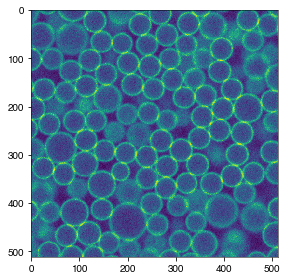

In [19]:
pl.imshow(stack_[0][:,:,50])

In [29]:
centres = deepcopy(stack[0])
edges= deepcopy(stack_[0])

In [6]:
bgd = filters.threshold_otsu(edges.ravel())
cts = filters.threshold_otsu(edges[edges>bgd].ravel())
print(bgd)
print(cts)

88
126


In [31]:
ccoords = pickle.load(open('/Volumes/Widows/20210223/data/centres.p','r'))
gr = pickle.load(open('/Volumes/Widows/20210223/data/gr_centres.p','r'))

In [19]:
ccoords.keys()

[0, 1, 2]

In [32]:
imp.reload(contact_spheres)
fminimum = 75
params = {}
params['d_iter'] = 1
params['s_iter'] = 3
forces = contact_spheres.Force(params,ccoords,stack_,fminimum)
contact_data = forces.get_todo()

<module 'contact_tracking.src.contact_spheres' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/contact_spheres.pyc'>

/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/scipy/ndimage/morphology.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0
/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/scipy/ndimage/measurements.py:429: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/scipy/ndimage/measurements.py:1278: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]
/Users/am15146/Documents/Tracking_code

In [33]:
imp.reload(utils)
directory = '/Volumes/Widows/20210223/data/'
fname = 'centres_contacts' 
type_ = 'xyz'
which = 'coms'
centres_={}

utils.saving_binary_xyz(directory,fname,ccoords,contact_data,type_,which1='centres',which2='coms')


<module 'contact_tracking.src.utils' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/utils.pyc'>

data directory has been created


In [119]:
contact_data[2]['force_hist'].keys()

['otsu_88']

In [120]:
hists = contact_data[2]['force_hist']['otsu_88']

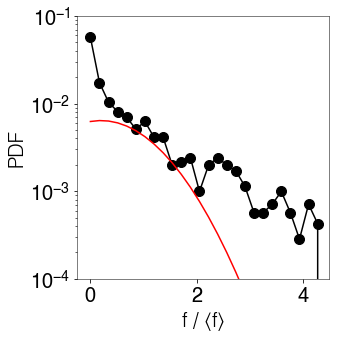

In [121]:
fig,axs = pl.subplots(1,1,figsize=(5,5))
axs.semilogy(hists[1],hists[4],marker='o',ms=10)
axs.set_xlim([-0.25,4.5])
axs.set_yscale('log')
axs.set_ylabel('PDF')
axs.set_xlabel('f / $\langle f \\rangle$')

fit = gauss(hists[1],0.0064,0.2,0.9)
axs.plot(hists[1],fit, label = 'Gaussian Fit')

axs.set_ylim([1e-4,1e-1])
# axs.legend()
fig.tight_layout();

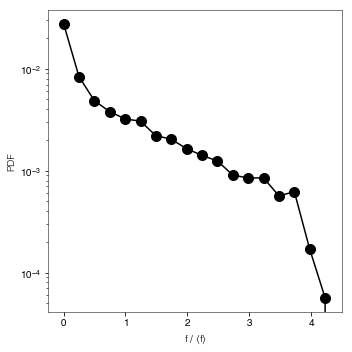

In [131]:
fig,axs = pl.subplots(1,1,figsize=(5,5))
axs.semilogy(histograms[0][1],histograms[0][4],marker='o',ms=10)
axs.set_xlim([-0.25,4.5])
axs.set_yscale('log')
axs.set_ylabel('PDF')
axs.set_xlabel('f / $\langle f \\rangle$')

# axs.set_ylim([1e-4,4e-2])
# axs.legend()
fig.tight_layout();

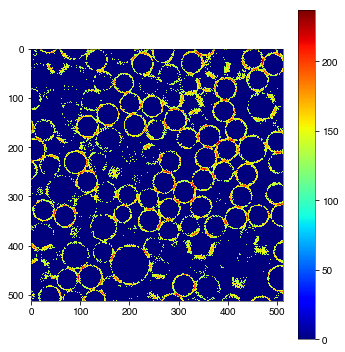

In [41]:
z = 45
pl.figure(figsize=(5,5))
pl.imshow(edges[:,:,z],cmap = 'jet')
pl.colorbar()

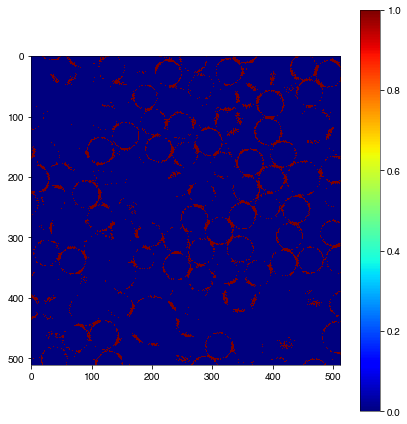

In [42]:
thres = 150
edges[edges<thres] = 0
edges[edges>=thres] = 1


pl.figure(figsize= (6,6))
pl.imshow(edges[:,:,z],cmap = 'jet')
pl.colorbar()

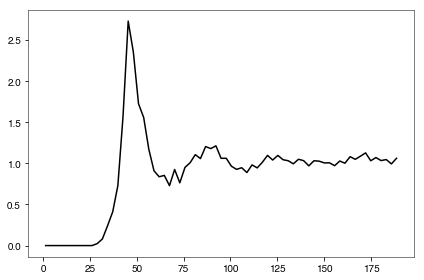

In [15]:
pl.plot(gr[0],gr[1])

In [43]:
wsigma = gr[1].argmax()
sigma = gr[0][wsigma]

wfminimum = gr[1][wsigma:wsigma*2].argmin() + wsigma
fminimum = gr[0][wfminimum]
print(fminimum)

67.46376811594203


In [12]:
# imp.reload(ds)
pcen = ccoords[0]['centres']
neighs = ds.get_neighs(pcen, maxdist=75)

/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


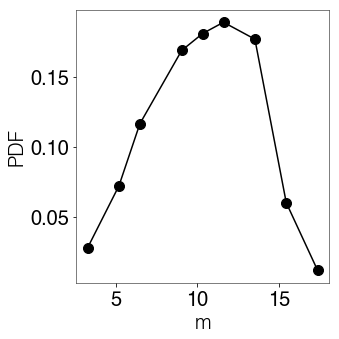

In [233]:
from peakutils import indexes

nn = [len(neighs[x]) for x in neighs]

h,e = np.histogram(nn,bins = 25,normed=True)
bc = np.array(e - np.diff([e[1],e[0]]))[:-1]

peaks = indexes(h,thres=0.05,min_dist=0)
fig,axs = pl.subplots(1,1,figsize=(5,5))
axs.plot(bc[peaks],h[peaks],marker = 'o',ms = 10)
axs.set_xlabel('m')
axs.set_ylabel('PDF')

fig.tight_layout();
pl.savefig('/Volumes/Widows/20210331/neigh_distr.pdf');

In [13]:
imp.reload(ds)
mask, mid_points = ds.get_middle_points(pcen,neighs,centres.shape)
mask_thr = 0# threshold_contact
spheres, dimmask,struct_size = ds.draw_spheres(mask,centres,mask_thr,s_iter=3,d_iter=1)

<module 'contact_tracking.src.draw_spheres' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/draw_spheres.pyc'>

/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/scipy/ndimage/morphology.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


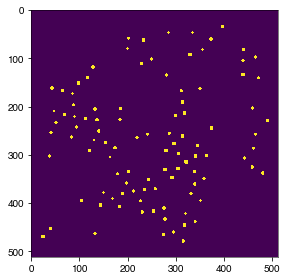

In [47]:
z = 50
pl.imshow(spheres[:,:,z])

In [15]:
labelled_mask, num_lab_mask = ndimage.label(spheres)
mask_size = ndimage.sum(spheres,labelled_mask, range(0,num_lab_mask+1))

/Users/am15146/.pyenv/versions/2.7.17/envs/py2/lib/python2.7/site-packages/scipy/ndimage/measurements.py:429: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


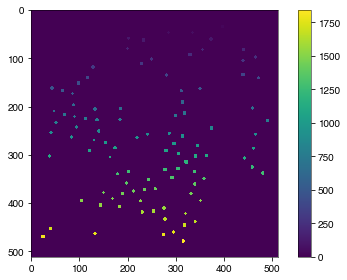

In [74]:
pl.imshow(labelled_mask[:,:,50])
pl.colorbar()

In [16]:
thres = cts
img_contacts = deepcopy(stack_[0])
mask = labelled_mask
which = 0

ROI = (img_contacts > thres).astype(int)
residualContacts = ROI * mask
residualLabels = np.unique(residualContacts[residualContacts > 0])
volumeResiduals = ndimage.sum(residualContacts > 0,residualContacts, residualLabels)
# volumeResiduals = volumeResiduals[volumeResiduals<800] #?????
print (thres,len(volumeResiduals))
#     print np.bincount(maxima)
H,edges= np.histogram(volumeResiduals, bins=30)
halfbwidth = (edges[1]-edges[0])/2
x =(edges[:-1]+halfbwidth)
xx =(x- x[H.argmax()])/(volumeResiduals.std()) # scaling with both peak value and std
xxx =x/ volumeResiduals.mean()  # scaling with peak value
xxxx = x/x[which:][H[which:].argmax()] #[1:] in case the max p(f) is at x=0


(126, 906)


In [26]:
residualLabels.shape

(906,)

In [19]:
def find_nan(tracked_centers):
    nan_li = []
    for i in range(len(tracked_centers)):
        if np.isnan(tracked_centers[i]).any():
            nan_li.append(i)
    nan_li = np.array(nan_li)
    new_centers = np.delete(np.array(tracked_centers),nan_li,0)
    return new_centers,nan_li

coms=ndimage.measurements.center_of_mass(residualContacts > 0,residualContacts,index = range(1,residualLabels.max()+1))

maxs = ndimage.measurements.maximum_position(residualContacts > 0,residualContacts,index = range(1,residualLabels.max()+1))

new_coms,nan_li = find_nan(coms)
new_maxs = np.delete(maxs,nan_li,0)
shifted_maxs=(np.array(new_coms) + np.array(new_maxs)) / 2.
not_nan = np.setdiff1d(residualLabels,(nan_li + 1))
contact_size = ndimage.sum(residualContacts > 0,residualContacts, not_nan)

3

In [53]:
imp.reload(ds)
thr_low = cts - 10
thr_high = cts + 10
delta_thr = 4
low_threshold = range(thr_low,thr_high,delta_thr)
histograms = [ds.force_pdf(img_contacts,mask,intensity) for intensity in low_threshold]


<module 'contact_tracking.src.draw_spheres' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/draw_spheres.pyc'>

/Users/am15146/Documents/Tracking_codes/contact_tracking/src/draw_spheres.py:378: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist,bedges= np.histogram(volumeResiduals, bins=30,normed = True)


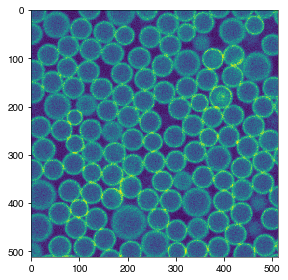

In [87]:
pl.imshow(img_contacts[:,:,0])

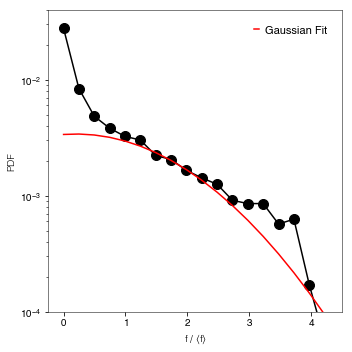

In [54]:


fig,axs = pl.subplots(1,1,figsize=(5,5))
axs.semilogy(histograms[0][1],histograms[0][4],marker='o',ms=10)
axs.set_xlim([-0.25,4.5])
axs.set_yscale('log')
axs.set_ylabel('PDF')
axs.set_xlabel('f / $\langle f \\rangle$')

fit = gauss(histograms[0][1],0.0034,0.2,1.5)
axs.plot(histograms[0][1],fit, label = 'Gaussian Fit')
axs.set_ylim([1e-4,4e-2])
axs.legend()
fig.tight_layout();
# pl.savefig('/Volumes/Widows/20210331/force_pdf.pdf');
# pl.semilogy(xx,H)

In [261]:
np.std(histograms[0][1])

2.147267359806955

In [56]:
histograms[0][5].shape

(898,)

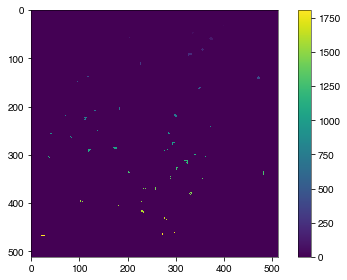

In [133]:
residualContacts = ROI * mask
pl.imshow(residualContacts[:,:,z])
pl.colorbar()

In [165]:
ccoords = np.where(residualContacts != 0)
ccoords[0].shape,ccoords[1].shape,ccoords[2].shape

((36569,), (36569,), (36569,))

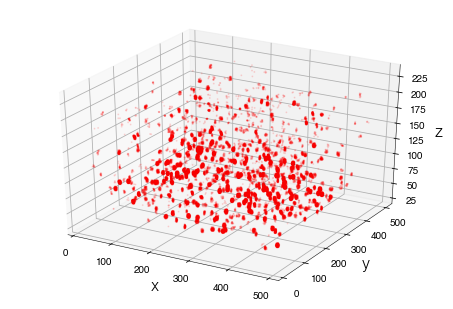

In [177]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(ccoords[0],ccoords[1],ccoords[2],alpha = 0.1,s=1,c = 'r')

ax.set_xlabel('x',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
ax.set_zlabel('z',fontsize = 16)


fig.tight_layout();
pl.savefig('/Volumes/Widows/20210331/centres.png');

In [156]:
centres.

(512,)

In [23]:
def normalise(img):
    fix_y = img / np.reshape( img.mean(2).mean(0), (1, img.shape[1], 1) )
    fix_z = fix_y / np.reshape( fix_y.mean(0).mean(0), (1, 1, img.shape[2]) )
    fix_x = fix_z / np.reshape( fix_z.mean(-1).mean(-1), (img.shape[0], 1, 1) )
    fix_x = fix_x / fix_x.max() * 255
    roi = tuple([slice(0, img.shape[0]), slice(0, img.shape[1]), slice(0, None)])
    return fix_x[roi]


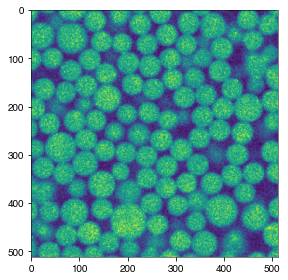

In [117]:
z = 50
xyz = deepcopy(stack[0])
# xyz_ = normalise(xyz)
slice_ = xyz_[:,:,z]
mxyz = ndimage.median_filter(slice_, 1)
bxyz = ndimage.gaussian_filter(mxyz, 1)
pl.imshow(bxyz)
# pl.imshow(xyz[:,:,z])

(array([ 2696.,  7249.,  8854.,  9580., 10124., 10178., 10545., 10879.,
        11389., 12580., 13475., 14675., 17196., 20076., 26534., 33546.,
        27071., 11790.,  3078.,   629.]),
 array([ 7.46567746,  9.27711016, 11.08854285, 12.89997555, 14.71140824,
        16.52284094, 18.33427363, 20.14570633, 21.95713902, 23.76857172,
        25.58000442, 27.39143711, 29.20286981, 31.0143025 , 32.8257352 ,
        34.63716789, 36.44860059, 38.26003329, 40.07146598, 41.88289868,
        43.69433137]),
 <a list of 20 Patch objects>)

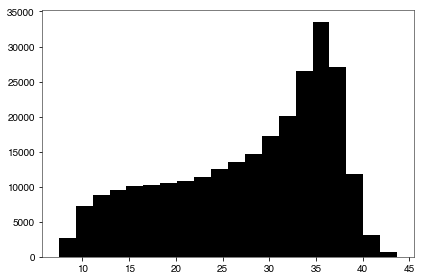

In [94]:
pl.hist(bxyz.ravel(),bins=20)

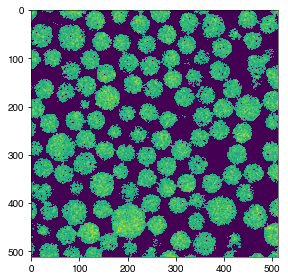

In [118]:
thres = 30
bxyz[bxyz<thres] = 0
# bxyz[bxyz>=thres] = 1
pl.imshow(bxyz)

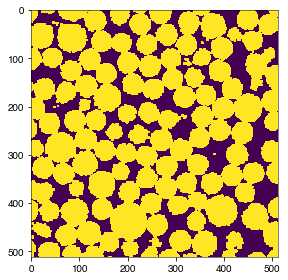

In [119]:
struct = ndimage.generate_binary_structure(2, 2)
struct_iter = ndimage.iterate_structure(struct,2).astype(int)
binary = ndimage.binary_dilation(bxyz,structure=struct_iter, iterations=1)
pl.imshow(binary)

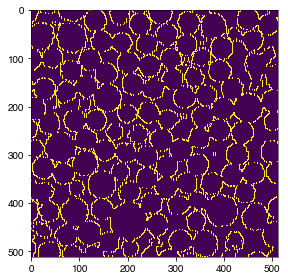

In [120]:
sobel = ndimage.filters.sobel(binary)
pl.imshow(sobel)

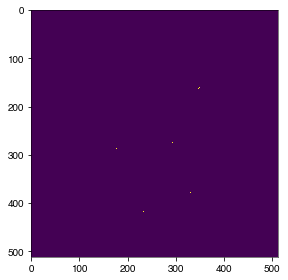

In [131]:
z=50
result = edges[:,:,z] * spheres[:,:,z] #mask[:,:,z]
pl.imshow(result)

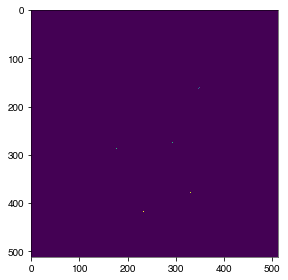

In [132]:
result = edges[:,:,z] * mask[:,:,z] 
pl.imshow(result)

In [90]:
np.unique(mask[:,:,z])

array([   0,   10,   66,   67,  112,  122,  129,  249,  263,  382,  523,
        552,  563,  574,  591,  625,  662,  686,  706,  712,  733,  761,
        812,  901,  915,  920,  939,  963,  972, 1008, 1111, 1117, 1135,
       1152, 1203, 1227, 1271, 1294, 1305, 1374, 1446, 1453, 1487, 1489,
       1630, 1631, 1642, 1685, 1830], dtype=int32)

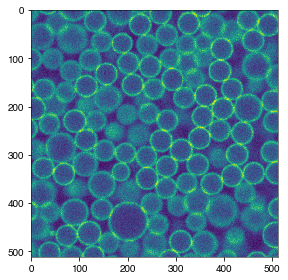

In [79]:
pl.imshow(img_contacts[:,:,z])

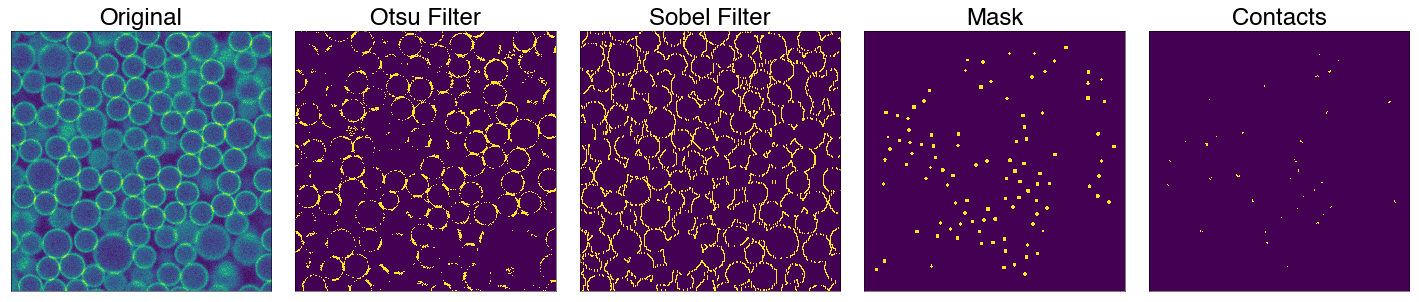

In [307]:
fig,axs = pl.subplots(1,5,figsize=(20,5))
axs = axs.ravel()

z = 50
axs[0].imshow(stack_[0][:,:,z])
axs[0].set_title('Original', fontsize = 24)

axs[1].imshow(edges[:,:,z])
axs[1].set_title('Otsu Filter', fontsize = 24)

axs[2].imshow(sobel)
axs[2].set_title('Sobel Filter', fontsize = 24)

axs[3].imshow(spheres[:,:,z])
axs[3].set_title('Mask', fontsize = 24)

axs[4].imshow(edges[:,:,z]*spheres[:,:,z])
axs[4].set_title('Contacts', fontsize = 24)

for i in range(5):
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    
fig.tight_layout();
# pl.savefig('/Volumes/Widows/20210331/filters.pdf');

In [14]:
from tcc_python_scripts.file_readers import xyz
from tcc_python_scripts.tcc import wrapper
# imp.reload(xyz)

xyz_file = '/Users/am15146/Desktop/EG_Water.xyz'
# particle_coordinates = list(xyz.read(xyz_file))
# print(particle_coordinates)

box = [510, 510, 740]
TCC_setup = wrapper.TCCWrapper()
TCC_setup.set_tcc_executable_directory("/Users/am15146/Documents/Tracking_codes/TCC/")
# Get the coordinates. The file_readers scripts are a good way to read in coordinates from a file.

TCC_setup.input_parameters['Run']['Frames'] = 1
results = TCC_setup.run(box, ccoords[0]['centres'])

AttributeError: 'module' object has no attribute 'which'

In [11]:
ccoords[0]['centres'].shape

(390, 4)

In [15]:
import shutil

In [16]:
shutil.which

Exception AttributeError: "TCCWrapper instance has no attribute 'cleanup'" in <bound method TCCWrapper.__del__ of <tcc_python_scripts.tcc.wrapper.TCCWrapper instance at 0x119e33a00>> ignored


AttributeError: 'module' object has no attribute 'which'